In [1]:
################# Test parameters ######################

# Actual physical parameters
BETA = 10 # inverse temperature
K = 7 # number of fermionic modes <-- They use K=17 in the paper
J = 9
Q = 4
LAMBDA_1 = 1
LAMBDA_2 = 10
TAU_TEST = 1/4

# Computational stuff
N_ITER = 11 # Number of iterations for which run the Schwinger-Dyson equation

In [2]:
import os 
import time
import copy
from tqdm import tqdm

import numpy as np 
import matplotlib.pyplot as plt
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad
import pandas as pd

from joblib import Parallel, delayed
from numba import jit, njit, prange


################## Locals #############################
from hamiltonian_generation import make_H4_sparse


#################### Macros #############################
np.random.seed(0)

# Physical constants
N = 2*K # number of fermions
N_DIM = 2**K # Hilbert space dimensions
TAU_RANGE = np.arange(-BETA, BETA, 0.1) # imaginary-time domain

# Computational stuff
N_SAMPLES = 160 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel
E_ORDER = 19 # Order to keep of matrix-exponential expansion. Also not given in the paper.

# Directory to save sample Hamiltonians
H_DIR = os.path.join("Simulated Hamiltonians", f"H4_K{K}_J{J}_Q{Q}")
os.makedirs(H_DIR, exist_ok=True)

######## Define Hamiltonian function ###################
H4_func, psi, psi_pairs, psi_quads = make_H4_sparse(K, J, precompute_pairs = True, precompute_quads = True)

####### Define test set ################################
try:
    js_test = np.load(os.path.join("Excel", "Benchmarks", f"js_test_K{K}_J{J}_Q{Q}.npy"))
    H_test = np.load(os.path.join("Excel", "Benchmarks", f"H_test_K{K}_J{J}_Q{Q}.npy"))
    iv_test = np.load(os.path.join("Excel", "Benchmarks", f"iv_test_K{K}_J{J}_Q{Q}.npy"))
except FileNotFoundError: 
    sigma_j = np.sqrt((J**2)*np.math.factorial(Q-1)/(N**(Q-1)))
    j_test = np.random.normal(0, sigma_j, size=tuple([N for i in range(Q)]))
    H_test = H4_func(j_test).toarray()
    iv_test = np.linalg.eigvalsh(H_test)

    np.save(os.path.join("Excel", "Benchmarks", f"js_test_K{K}_J{J}_Q{Q}.npy"), j_test)
    np.save(os.path.join("Excel", "Benchmarks", f"H_test_K{K}_J{J}_Q{Q}.npy"), H_test)
    np.save(os.path.join("Excel", "Benchmarks", f"iv_test_K{K}_J{J}_Q{Q}.npy"), iv_test)

## Define fast matrix-exponential

In [3]:
# Define matrix exponential function
# For K=10, E_ORDER=19 is optimal
# For K=12, E_ORDER=13 is optimal
# See "spectral_form_factor.ipynb"

def matrix_exponential(A, n): # A = matrix, n = order of expansion
    out = np.zeros(A.shape, dtype=np.complex128)
    last_term = np.identity(A.shape[0])
    out += last_term
    for i in range(1, n+1):
        last_term = last_term @ A / i
        out += last_term
    return out

## Define exact, finite-N 2-point function

In [4]:

def G_finite_exact(psi_a, psi_b, H, tau, beta, lam):
    # psi_a, psi_b = fermions
    # tau = imaginary time
    # beta = inverse temperature
    # lam = beta*J
    # Note: a,b,tau,beta,lam are all scalars

    # Note that this if/else basically defines the time-ordering operator
    if tau>0: 
        E_tau = matrix_exponential(-tau*H*lam, E_ORDER)
        E_beta_tau = matrix_exponential((-beta+tau)*H*lam, E_ORDER)
        #E_tau = expm(-tau*H*lam)
        #E_beta_tau = expm((-beta+tau)*H*lam)
        num = np.trace(E_beta_tau @ psi_a @ E_tau @ psi_b)
        den = np.trace(E_beta_tau @ E_tau)
        return num/den
    else:
        E_tau = matrix_exponential(tau*H*lam, E_ORDER)
        E_beta_tau = matrix_exponential(-(beta+tau)*H*lam, E_ORDER)
        #E_tau = expm(tau*H*lam)
        #E_beta_tau = expm(-(beta+tau)*H*lam)
        num = np.trace(E_beta_tau @ psi_b @ E_tau @ psi_a)
        den = np.trace(E_beta_tau @ E_tau)
        return -num/den

In [5]:
later="""
def G_finite_exact(psi_a, psi_b, H, tau, beta, lam):
    # psi_a, psi_b = fermions
    # tau = imaginary time
    # beta = inverse temperature
    # lam = beta*J
    # Note: a,b,tau,beta,lam are all scalars

    # Note that this if/else basically defines the time-ordering operator
    if tau>0: 
        E_tau = matrix_exponential(-tau*H*lam, E_ORDER)
        E_beta_tau = matrix_exponential((-beta+tau)*H*lam, E_ORDER)
        #E_tau = expm(-tau*H*lam)
        #E_beta_tau = expm((-beta+tau)*H*lam)
        num = np.trace(E_beta_tau @ psi_a @ E_tau @ psi_b)
        den = np.trace(E_beta_tau @ E_tau)
        return 0.5*np.sign(tau)+num/den
    else:
        E_tau = matrix_exponential(tau*H*lam, E_ORDER)
        E_beta_tau = matrix_exponential(-(beta+tau)*H*lam, E_ORDER)
        #E_tau = expm(tau*H*lam)
        #E_beta_tau = expm(-(beta+tau)*H*lam)
        num = np.trace(E_beta_tau @ psi_b @ E_tau @ psi_a)
        den = np.trace(E_beta_tau @ E_tau)
        return 0.5*np.sign(tau)-num/den"""

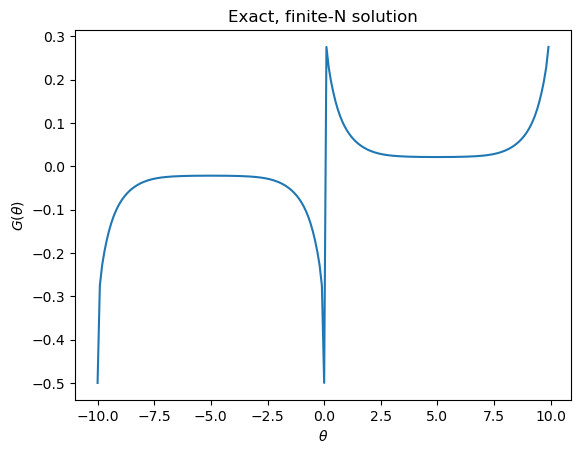

In [6]:
psi_a = psi[0]
psi_b = psi[0]

G_finite_range = Parallel(n_jobs=N_JOBS)(delayed(G_finite_exact)(psi_a, psi_b, H_test, tau, BETA, LAMBDA_1) for tau in TAU_RANGE)
G_finite_range = np.real(np.array(G_finite_range))

plt.figure()
plt.plot(TAU_RANGE, G_finite_range)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$G(\theta)$")
plt.title("Exact, finite-N solution")
plt.show()
plt.close()

## Define Schwinger-Dyson 2-point function (i.e. large-N limit of 2-point function)

$\Sigma^{(0)}(n)=0$

$\Sigma^{(i)}(n) = \int_{-\beta/2}^{\beta/2} J^2 [G_{\tau}^{(i-1)} (\tau)]^{q-1} e^{i\omega_{n}\tau} d\tau$

$G^{(i)}(n) = -1/(i\omega_{n}+\Sigma^{(i)}(n))$

$G_\tau^{(i)}(\tau) = \frac{1}{2}sign(\tau) + \frac{1}{\beta} \sum_{n=-\lambda}^\lambda e^{-i \omega_n \tau} (G^{(i)}(n) - G^{(0)}(n))$

$\omega_n=\frac{2\pi}{\beta}(n+1/2)$

In [7]:
# TODO: Study numerical integration effects, discretization limit and errors, different integration method, parallelization

sigma_memo = {}
sigma_tau_memo = {}
sigma_integrand_memo = {}
G_memo = {}
G_tau_memo = {}

def sigma_tau(i, tau):
    if (i,tau) in sigma_tau_memo:
        return sigma_tau_memo[(i, tau)]
    else:
        out = (J**2)*(G_tau(i-1, tau)**(Q-1))
        sigma_tau_memo[(i,tau)] = out
    return out

def sigma_integrand(tau, i, n):
    if (tau, i, n) in sigma_integrand_memo:
        return sigma_integrand_memo[(tau, i, n)]
    else:
        w_n = (2*np.pi/BETA)*(n+1/2)
        integrand = (J**2)*(G_tau(i-1, tau)**(Q-1))*np.exp(1j*w_n*tau)
        sigma_integrand_memo[(tau, i, n)] = integrand
    return integrand

def sigma(i,n):
    if (i,n) in sigma_memo:
        return sigma_memo[(i,n)]
    else:
        if i==0:
            sigma_memo[(i,n)] = 0
            return 0
        else:
            #integral = quad(sigma_integrand, -BETA/2, BETA/2, args=(i,nn))[0]
            
            #w_nn = (2*np.pi/BETA)*(nn+1/2)
            #integrand = lambda tau: (J**2)*(G_tau(i-1, tau)**(Q-1))*np.exp(-1j*w_nn*tau)
            #integral = integrate.quad(integrand, -BETA/2, BETA/2)[0]
            # Doesn't work

            #dtau=1e-4
            #integrands = Parallel(n_jobs=N_JOBS)(delayed(sigma_integrand)(t, i, nn) for t in np.linspace(-BETA/2, BETA/2, int(1e4)))
            #integral = dtau*np.sum(np.array(integrands))  
            # Doesn't work

            w_n = (2*np.pi/BETA)*(n+1/2)
            dtau=1e-4
            integral = 0                                
            for tau in np.linspace(-BETA/2, BETA/2, int(1e4)):
                integrand = sigma_tau(i, tau)*np.exp(1j*w_n*tau)
                integral += dtau*integrand
            # single: 6.5 s
            # tau_range: 23.8 s
            
            #dtau=1e-4
            #tau_range = np.linspace(-BETA/2, BETA/2, int(1e4))
            #integrands = np.array([sigma_integrand(tau, i, nn) for tau in tau_range])
            #integral = np.trapz(integrands, dx=dtau)  
            # single: 8.9 s
            # tau_range: over 2 minutes    

            #dtau=1e-4
            #tau_range = np.linspace(-BETA/2, BETA/2, 1e4)
            #integrands = np.array([sigma_integrand(tau, i, nn) for tau in tau_range])
            #integral = np.trapz(integrands, tau_range)  
            # single: 10.9s
            # tau_range: over 2 minutes     
            
            sigma_memo[(i,n)] = integral
            return integral
        
def G(i, n):
    if (i,n) in G_memo:
        return G_memo[(i,n)]
    else:
        w_n = (2*np.pi/BETA)*(n+1/2)
        den = 1j*w_n + sigma(i, n)

        #x = 0.5
        #out = (1-x)*G(i-1, nn)-x/den
        out = -1/den
        G_memo[(i,n)] = out
        return out

def G_tau(i, tau):
    if (i, tau) in G_tau_memo:
        return G_tau_memo[(i,tau)]
    else:
        sum = 0
        for n in range(-int(LAMBDA_2), int(LAMBDA_2)):
            w_n = (2*np.pi/BETA)*(n+1/2)
            summand_n = np.exp(-1j*w_n*tau)*(G(i, n)-G(0,n))
            sum += summand_n

        out = 0.5*np.sign(tau)+sum/BETA
        G_tau_memo[(i,tau)] = out
        return out

(0.4604273905210897-4.814725007573628e-16j)


c:\Users\abdel\anaconda3\envs\phys417\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


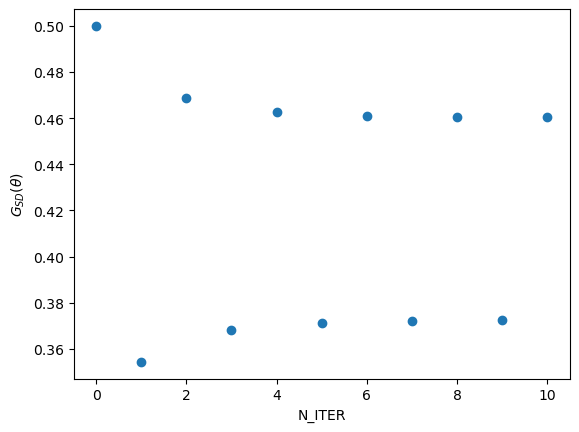

In [8]:
i_range = np.arange(N_ITER)

G_tau_irange = np.zeros(i_range.shape, dtype=np.complex128)
for i in i_range:
    G_tau_irange[i] = G_tau(i, TAU_TEST)

print(G_tau_irange[-1])
plt.figure()
plt.scatter(i_range, G_tau_irange)
plt.xlabel("N_ITER")
plt.ylabel(r"$G_{SD}(\theta)$")
plt.show()
plt.close()

In [9]:
G_SD_range = Parallel(n_jobs=N_JOBS)(delayed(G_tau)(N_ITER, tau) for tau in TAU_RANGE)

In [ ]:
plt.figure()
plt.plot(TAU_RANGE, G_finite_range, label="Exact, finite-N solution", c="b")
plt.plot(TAU_RANGE, G_SD_range, label="Schwinger-Dyson", c="b", linestyle="dashed",)

# Plot axes
y_range = np.linspace(np.max(G_SD_range), np.min(G_SD_range), 100)
plt.plot([0 for i in y_range], y_range, c="k")
x_range = np.linspace(np.min(TAU_RANGE), np.max(TAU_RANGE), 100)
plt.plot(x_range, [0 for i in x_range], c="k")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$G_{SD}(\theta)$")
plt.title(f"K = {K}, "+r"$\beta J = $"+f"{BETA*J}, "+"$\lambda_1 = $"+f"{LAMBDA_1}, "+"$\lambda_2 = $"+f"{LAMBDA_2}")
plt.legend()
plt.savefig(os.path.join("Images", f"K{K}_J{J:.2f}_Q{Q}_B{BETA}_L1{LAMBDA_1}_L2{LAMBDA_2}_2PNT.png"))
plt.show()
plt.close()

Not full agreement with Mathematica (see "schwinger_dyson.nb"). Our exact, finite results seem to match up. But our Schwinger-Dyson approximations do not. 

Could it be integration error??

Very strange mathematica behavior at:
- $\beta = 10$
- $K = 7$
- $J = 4$
- $Q = 4$
- $\lambda_1 = 1$
- $\lambda_2 = 10$
- $nIter = 11$
- $tauTest = 1/4$


And it gets EVEN STRANGER at $J=9$